In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage.filters import uniform_filter1d
from scipy.signal import find_peaks
from scipy import signal

import pylab
import os.path
from scipy.signal import butter , filtfilt
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import KFold

2021-11-26 21:34:18.062273: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-26 21:34:18.062313: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# Reading the data and initialising the used arrays for the data and the label

# Shapes of arrays
# Training input:  (750, 40000,4)
# Training label:  (750,)
# Subject label:   (750,)
training_data=np.zeros((100,13000,4))
training_label=np.zeros((100))
training_subject=np.zeros((100))
training_data_len=np.zeros((100))
training_data_freq=np.zeros((100))
k=0

s_id = ['215', '216', '217']

for i in s_id:
    
    for j in range(2):
        
        path_norm="./Data/Smartphone3/subject"+i.zfill(2)+"_normal0"+str(j+1)+"/Accelerometer.csv"
        path_up="./Data/Smartphone3/subject"+i.zfill(2)+"_upstairs0"+str(j+1)+"/Accelerometer.csv"
        path_down="./Data/Smartphone3/subject"+i.zfill(2)+"_downstairs0"+str(j+1)+"/Accelerometer.csv"

        #print(path_norm, path_up, path_down)
        
        if os.path.isfile(path_norm): 
            
            data_norm=pd.read_csv(path_norm,sep=",")
            training_data[k,0:len(data_norm["Time(s)"]),0]= data_norm["Time(s)"]
            training_data[k,0:len(data_norm["X(m/s^2)"]),1]=data_norm["X(m/s^2)"]
            training_data[k,0:len(data_norm["Y(m/s^2)"]),2]=data_norm["Y(m/s^2)"]
            training_data[k,0:len(data_norm["Z(m/s^2)"]),3]=data_norm["Z(m/s^2)"]
            training_data_len[k]=len(data_norm["Time(s)"])
            training_label[k]=0
            training_subject[k]=i
            #print(training_data[k,:])
            k=k+1
                
        if os.path.isfile(path_up): 
            
            data_up=pd.read_csv(path_up,sep=",")
            training_data[k,0:len(data_up["Time(s)"]),0]= data_up["Time(s)"]
            training_data[k,0:len(data_up["X(m/s^2)"]),1]=data_up["X(m/s^2)"]
            training_data[k,0:len(data_up["Y(m/s^2)"]),2]=data_up["Y(m/s^2)"]
            training_data[k,0:len(data_up["Z(m/s^2)"]),3]=data_up["Z(m/s^2)"]
            training_data_len[k]=len(data_up["Time(s)"])
            training_label[k]=1
            training_subject[k]=i
            #print(training_data[k,:])
            k=k+1
                
        if os.path.isfile(path_down): 
            
            data_down=pd.read_csv(path_down,sep=",")
            training_data[k,0:len(data_down["Time(s)"]),0]= data_down["Time(s)"]
            training_data[k,0:len(data_down["X(m/s^2)"]),1]=data_down["X(m/s^2)"]
            training_data[k,0:len(data_down["Y(m/s^2)"]),2]=data_down["Y(m/s^2)"]
            training_data[k,0:len(data_down["Z(m/s^2)"]),3]=data_down["Z(m/s^2)"]
            training_data_len[k]=len(data_down["Time(s)"])
            training_label[k]=2
            training_subject[k]=i
            #print(training_data[k,:])
            k=k+1
                
number_of_imputs=k

In [4]:
#Get the frequency of the sensors
for i in range(number_of_imputs):
    
    #print(training_data[i,int(training_data_len[i]-1),0])
    training_data_freq[i]=(training_data_len[i]-1)/training_data[i,int(training_data_len[i]-1),0]
    #print(training_data_freq[i])

In [5]:
# Filter of the data
# This first filter is used on the data


cutFreq = 10
training_data_filtered=np.zeros((100,13000,4))
training_data_filtered[:,:,0]=training_data[:,:,0]
"A single Butterworth filter with a cutoff frequency between 0.1 and 15 Hz is "
"sufficient to reduce a large component of noise from the data and serves "
"as the best preprocessing step"
#     sampling_rate = round(3/(time[2]-time[1]),3)    # sampling rate 416 HZ 
for i in range(number_of_imputs):
    for j in range(1,4):
        sampling_rate=training_data_freq[i]
        cuttoff_freq = cutFreq/(0.5*sampling_rate)  
        b,a = butter(2, cuttoff_freq, btype = 'low',analog= False)
        data = training_data[i,:int(training_data_len[i]-1),j] #dataset.iloc[:,1:2]
        data = np.transpose(data)
        filtered_data = filtfilt(b,a,data)
        training_data_filtered[i,:int(training_data_len[i]-1),j] = np.transpose(filtered_data)

In [6]:
# This second filter is only used to find the extraction points on the data
# With the low cut of frequency only a sinusoidal oscillation remains

cutFreq = 1
training_data_filtered_2=np.zeros((100,13000,4))
training_data_filtered_2[:,:,0]=training_data[:,:,0]
"A single Butterworth filter with a cutoff frequency between 0.1 and 15 Hz is "
"sufficient to reduce a large component of noise from the data and serves "
"as the best preprocessing step"
#     sampling_rate = round(3/(time[2]-time[1]),3)    # sampling rate 416 HZ 
for i in range(number_of_imputs):
    for j in range(1,4):
        sampling_rate=training_data_freq[i]
        cuttoff_freq = cutFreq/(0.5*sampling_rate)  
        b,a = butter(2, cuttoff_freq, btype = 'low',analog= False)
        data = training_data[i,:int(training_data_len[i]-1),j] #dataset.iloc[:,1:2]
        data = np.transpose(data)
        filtered_data = filtfilt(b,a,data)
        training_data_filtered_2[i,:int(training_data_len[i]-1),j] = np.transpose(filtered_data)

0.0
215.0
1.0
215.0
2.0
215.0


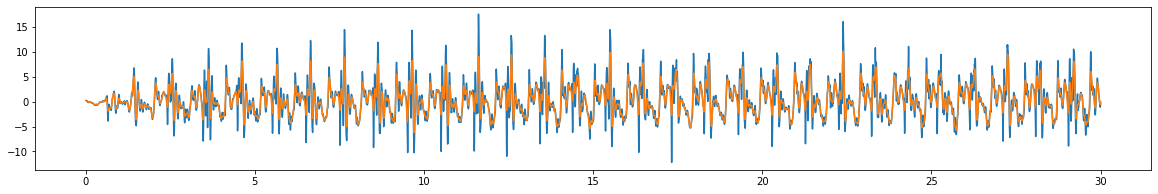

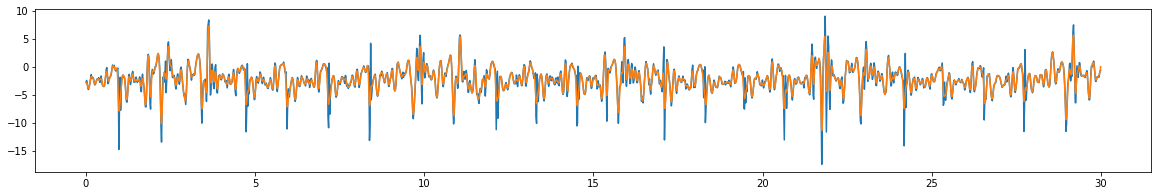

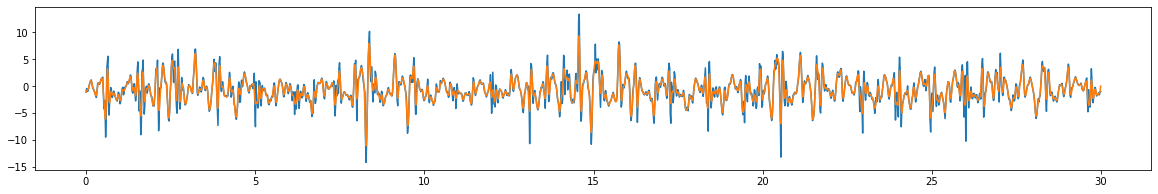

In [7]:
#Plot how the filtered data looks
for i in range(3):
    plt.rcParams["figure.figsize"] = (20,3)
    plt.figure(i)
    plt.plot(training_data[i,0:int(training_data_len[i]),0],training_data[i,0:int(training_data_len[i]),1])
    plt.plot(training_data_filtered[i,0:int(training_data_len[i]),0],training_data_filtered[i,0:int(training_data_len[i]),1])
    
    print(training_label[i])
    print(training_subject[i])

In [8]:
#Extraction
#The finding of the relevant peaks of the sinusoidal oscillation is easy 
#and the distance between the peaks is used to find the walking sequence

training_data_extracted=np.zeros((number_of_imputs,13000,4))
training_data_len_extracted=np.zeros((number_of_imputs))
peaks_i=np.zeros((number_of_imputs,700))

extract_start=0
extract_end=0
safe_range_factor=7
safe_range_factor_m=safe_range_factor-1
# for i in range(1,30):
for i in range(number_of_imputs):
    
    peak_indices, _ =find_peaks(training_data_filtered_2[i,0:int(training_data_len[i]),1], prominence=0.4)#,distance=150
    peak_distance=np.zeros(len(peak_indices))
    peaks_i[i,:len(peak_indices)]=peak_indices
    
    for k in range(len(peak_indices)-1):
        peak_distance[k]=peak_indices[k+1]-peak_indices[k]
        
    peak_distance_mean=np.mean(peak_distance[len(peak_distance)//safe_range_factor:safe_range_factor_m*len(peak_distance)//safe_range_factor])
    try:
        extract_start_peak=int(len(peak_distance)//safe_range_factor) - np.where(np.logical_or(np.flip(peak_distance[:len(peak_distance)//safe_range_factor]) > 1.2*peak_distance_mean , np.flip(peak_distance[:len(peak_distance)//safe_range_factor]) < 0.8*peak_distance_mean))[0][0]
        extract_end_peak=int(safe_range_factor_m*len(peak_distance)//safe_range_factor) - 1 + np.where(np.logical_or( peak_distance[safe_range_factor_m*len(peak_distance)//safe_range_factor:len(peak_distance)]  > 1.2*peak_distance_mean, peak_distance[safe_range_factor_m*len(peak_distance)//safe_range_factor:len(peak_distance)]< 0.8*peak_distance_mean))[0][0]
    except:
        extract_start_peak=int(len(peak_distance)//safe_range_factor)
        extract_end_peak=int(safe_range_factor_m*len(peak_distance)//safe_range_factor)
        
    extract_start=peak_indices[extract_start_peak]
    extract_end=peak_indices[extract_end_peak]
    
    
    training_data_len_extracted[i]=extract_end-extract_start
    
    for j in range(0,4):
        training_data_extracted[i,:int(training_data_len_extracted[i]),j]=training_data_filtered[i,extract_start:extract_end,j]
    
    

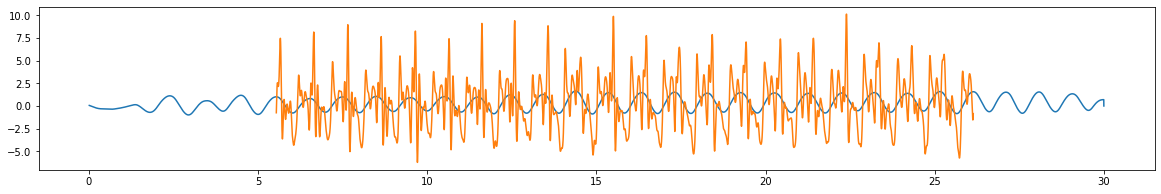

In [9]:
#Plot to show the extracted data

for i in range(1):
    plt.rcParams["figure.figsize"] = (20,3)
    plt.figure(i)
    plt.plot(training_data_filtered_2[i,0:int(training_data_len[i]),0],training_data_filtered_2[i,0:int(training_data_len[i]),1])
    plt.plot(training_data_extracted[i,0:int(training_data_len_extracted[i]),0],training_data_extracted[i,0:int(training_data_len_extracted[i]),1])

    

In [10]:
###Rotation 
#The Rotation of the data is based of the gravitational acceleration.
#This gets detected with the mean of the time series for every axis and the axis with the highest absolute value of the 
#mean gets set as the y-axis.
#

training_data_rotated=np.zeros((number_of_imputs,13000,4))

for i in range(number_of_imputs):
    
# for i in range(1):
    training_data_rotated[i,:int(training_data_len_extracted[i]),0]=training_data_extracted[i,:int(training_data_len_extracted[i]),0]
    
    #for j in range(1,4):
    mean_x=np.abs(np.mean(training_data_extracted[i,:int(training_data_len_extracted[i]),1]))
    mean_y=np.abs(np.mean(training_data_extracted[i,:int(training_data_len_extracted[i]),2]))
    mean_z=np.abs(np.mean(training_data_extracted[i,:int(training_data_len_extracted[i]),3]))
    
    mean_y_sign=np.mean(training_data_extracted[i,:int(training_data_len_extracted[i]),2])
    
    index=np.argmax([mean_x,mean_y,mean_z])
    if mean_y_sign>0:
        if index==0:
            training_data_rotated[i,:int(training_data_len_extracted[i]),2]=training_data_extracted[i,:int(training_data_len_extracted[i]),1]
            training_data_rotated[i,:int(training_data_len_extracted[i]),1]=training_data_extracted[i,:int(training_data_len_extracted[i]),2]
            training_data_rotated[i,:int(training_data_len_extracted[i]),3]=training_data_extracted[i,:int(training_data_len_extracted[i]),3]


        if index==1:
            training_data_rotated[i,:int(training_data_len_extracted[i]),3]=training_data_extracted[i,:int(training_data_len_extracted[i]),3]
            training_data_rotated[i,:int(training_data_len_extracted[i]),2]=training_data_extracted[i,:int(training_data_len_extracted[i]),2]
            training_data_rotated[i,:int(training_data_len_extracted[i]),1]=training_data_extracted[i,:int(training_data_len_extracted[i]),1]


        if index==2:
            training_data_rotated[i,:int(training_data_len_extracted[i]),2]=training_data_extracted[i,:int(training_data_len_extracted[i]),3]
            training_data_rotated[i,:int(training_data_len_extracted[i]),3]=training_data_extracted[i,:int(training_data_len_extracted[i]),2]
            training_data_rotated[i,:int(training_data_len_extracted[i]),1]=training_data_extracted[i,:int(training_data_len_extracted[i]),1]
    
    if mean_y_sign<0:

        if index==0:
            training_data_rotated[i,:int(training_data_len_extracted[i]),2]=-training_data_extracted[i,:int(training_data_len_extracted[i]),1]
            training_data_rotated[i,:int(training_data_len_extracted[i]),1]=training_data_extracted[i,:int(training_data_len_extracted[i]),2]
            training_data_rotated[i,:int(training_data_len_extracted[i]),3]=training_data_extracted[i,:int(training_data_len_extracted[i]),3]


        if index==1:
            training_data_rotated[i,:int(training_data_len_extracted[i]),3]=training_data_extracted[i,:int(training_data_len_extracted[i]),3]
            training_data_rotated[i,:int(training_data_len_extracted[i]),2]=-training_data_extracted[i,:int(training_data_len_extracted[i]),2]
            training_data_rotated[i,:int(training_data_len_extracted[i]),1]=training_data_extracted[i,:int(training_data_len_extracted[i]),1]


        if index==2:
            training_data_rotated[i,:int(training_data_len_extracted[i]),2]=-training_data_extracted[i,:int(training_data_len_extracted[i]),3]
            training_data_rotated[i,:int(training_data_len_extracted[i]),3]=training_data_extracted[i,:int(training_data_len_extracted[i]),2]
            training_data_rotated[i,:int(training_data_len_extracted[i]),1]=training_data_extracted[i,:int(training_data_len_extracted[i]),1]

    
    

In [11]:
#Segmentation
#Again filter with low cut of frequency used to get a clean sinusoidal oscillation to find the relevant peaks easily


cutFreq = 1.8
training_data_filtered_3=np.zeros((number_of_imputs,13000,4))
training_data_filtered_3[:,:,0]=training_data_rotated[:,:,0]
"A single Butterworth filter with a cutoff frequency between 0.1 and 15 Hz is "
"sufficient to reduce a large component of noise from the data and serves "
"as the best preprocessing step"
#     sampling_rate = round(3/(time[2]-time[1]),3)    # sampling rate 416 HZ 
for i in range(number_of_imputs):
    for j in range(1,4):
        sampling_rate=training_data_freq[i]
        cuttoff_freq = cutFreq/(0.5*sampling_rate)  
        b,a = butter(2, cuttoff_freq, btype = 'low',analog= False)
        data = training_data_rotated[i,:int(training_data_len_extracted[i]-1),j] #dataset.iloc[:,1:2]
        data = np.transpose(data)
        filtered_data = filtfilt(b,a,data)
        training_data_filtered_3[i,:int(training_data_len_extracted[i]-1),j] = np.transpose(filtered_data)

In [12]:
#The walking sequence gets cut into individual steps based on the peaks of the signal


training_data_sampled=np.zeros((number_of_imputs,190,1400,4)) ##number of input, number of samples, sampled data, axis

peaks_i=np.zeros((number_of_imputs,700))
num_of_peaks=np.zeros((number_of_imputs))
peak_distance_i=np.zeros((number_of_imputs,700))

# for i in range(30,40):
for i in range(number_of_imputs):
     
    peak_indices_1, _ =find_peaks(training_data_filtered_3[i,0:int(training_data_len_extracted[i]),2], prominence=0.5)#2.8 prom 5,distance=150 #,distance=training_data_freq[1]*0.5

    peak_indices=peak_indices_1
    peak_distance=np.zeros(len(peak_indices))
    peaks_i[i,:len(peak_indices)]=peak_indices
    num_of_peaks[i]=len(peak_indices)
    
    for j in range(len(peak_indices)-1):#

        peak_distance[j]=peak_indices[j+1]-peak_indices[j]
        
        peak_distance_i[i,j]=peak_distance[j]
        
        for k in range (4):
            training_data_sampled[i,j,:int(peak_distance[j]),k]=training_data_rotated[i,peak_indices[j]:peak_indices[j+1],k]
    
       
    
    
    

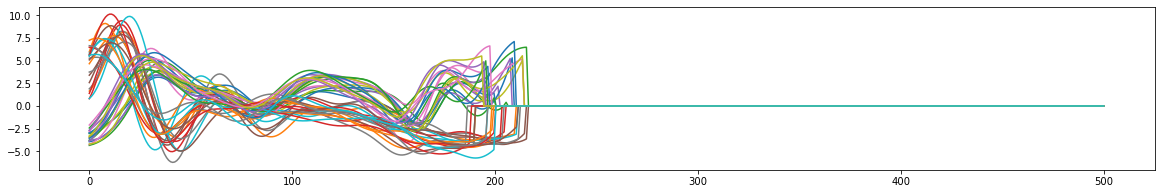

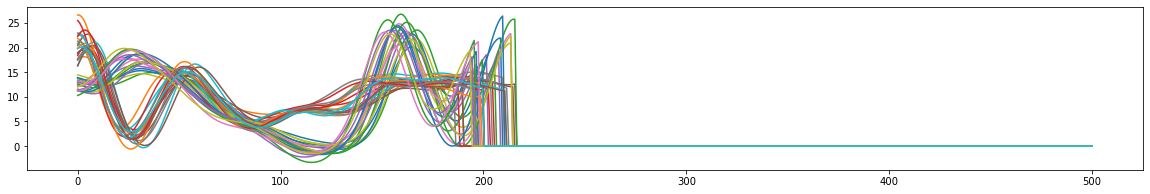

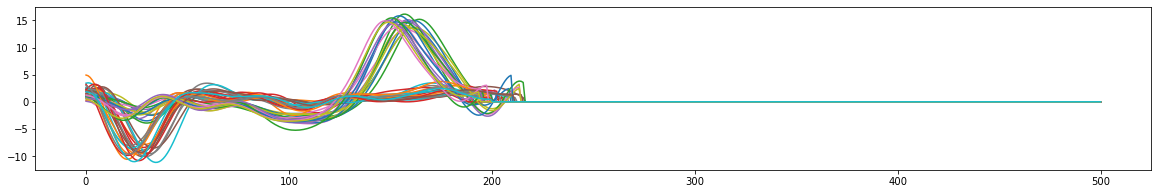

In [13]:
#Show Plot of segmented data but with different sample length
sample_length=500
for i in range(1): #(number_of_imputs):
# for i in range(number_of_imputs):

    for j in range(int(num_of_peaks[i])-1):#
        
        if training_label[i]==0:
            plt.figure(1)
            plt.rcParams["figure.figsize"] = (20,3)
            plt.plot(np.linspace(0,sample_length,sample_length),training_data_sampled[i,j,0:sample_length,1])
            plt.figure(2)
            plt.plot(np.linspace(0,sample_length,sample_length),training_data_sampled[i,j,0:sample_length,2])
            plt.figure(3)
            plt.plot(np.linspace(0,sample_length,sample_length),training_data_sampled[i,j,0:sample_length,3])





In [14]:
# Resample 
#Every step gets resampled to the same number of datapoints
#Two peaks from the segmentation make up one step and the order of the reconstruction gets adressed based on the maximum value. th

resample_length=200
training_data_resampled=np.zeros((number_of_imputs,int(np.max(num_of_peaks)//2-1),resample_length,3))

# for i in range(40):
for i in range(number_of_imputs):
    max_even=0
    max_odd=0
    for j in range((int(num_of_peaks[i]//2)-1)):#
        max_even+=np.max(training_data_sampled[i,2*j,:int(peak_distance_i[i,2*j])//2,2])
        max_odd+=np.max(training_data_sampled[i,2*j+1,:int(peak_distance_i[i,2*j+1])//2,2])
                    
    mean_max_even=max_even
    mean_max_odd=max_odd

    if mean_max_even>mean_max_odd:
        for j in range((int(num_of_peaks[i]//2)-1)):#
            for k in range(3):#
                x1=training_data_sampled[i,2*j,:int(peak_distance_i[i,2*j]),k+1]
                x2=training_data_sampled[i,2*j+1,:int(peak_distance_i[i,2*j+1]),k+1]
                x3=np.concatenate((x1,x2))
                #training_data_resampled[i,j,:,0]=
                training_data_resampled[i,j,:,k]=signal.resample(x3,resample_length)

    else:
        for j in range((int(num_of_peaks[i]//2)-2)):#                                                                                   
            for k in range(3):#
                x1=training_data_sampled[i,2*j+1,:int(peak_distance_i[i,2*j+1]),k+1]
                x2=training_data_sampled[i,2*j+2,:int(peak_distance_i[i,2*j+2]),k+1]
                x3=np.concatenate((x1,x2))
                #training_data_resampled[i,j,:,0]=
                training_data_resampled[i,j,:,k]=signal.resample(x3,resample_length)
#         print(i)

    
    

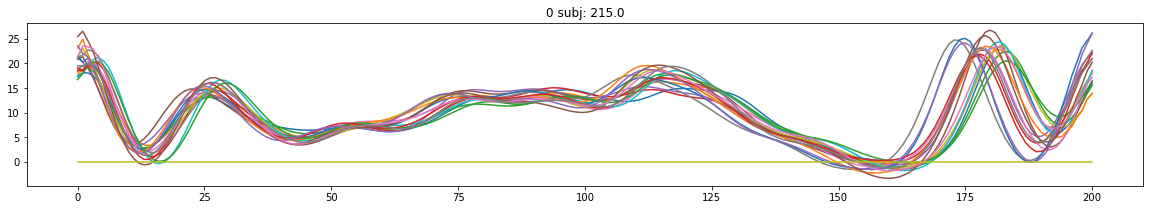

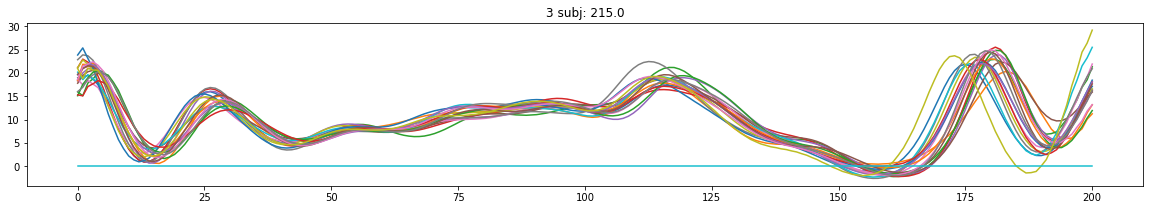

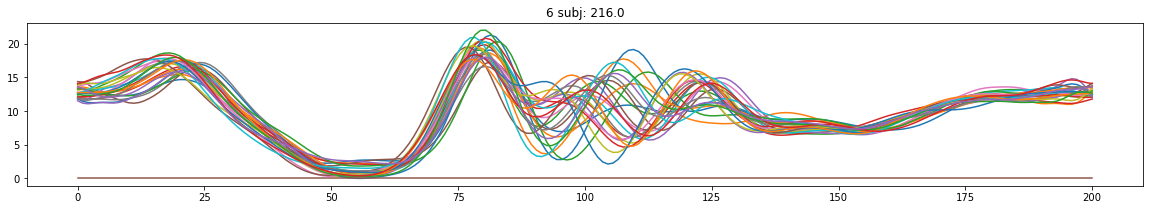

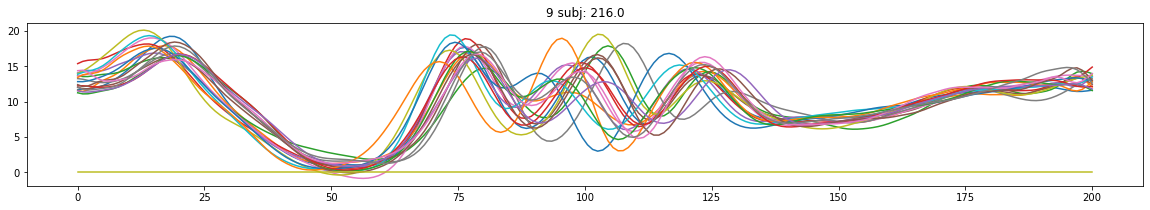

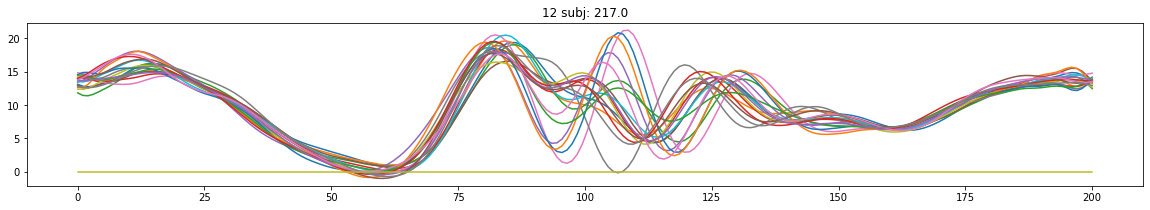

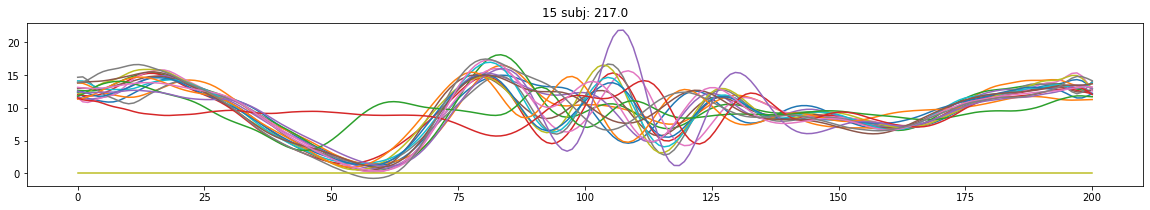

In [15]:
#Plot for the resampled data

for i in range(0,18): #(number_of_imputs):
# for i in range(number_of_imputs):

    for j in range(0,int(num_of_peaks[i])//2-1):#
        
        if training_label[i]==0:
#         if (j % 2) == 0:
            plt.rcParams["figure.figsize"] = (20,3)
#             plt.figure(3*i)
#             plt.title(str(i)+" subj: "+str(training_subject[i]))
#             plt.plot(np.linspace(0,resample_length,resample_length),training_data_resampled[i,j,0:resample_length,0])
            
            plt.figure(3*i+1)
            plt.title(str(i)+" subj: "+str(training_subject[i]))
            plt.plot(np.linspace(0,resample_length,resample_length),training_data_resampled[i,j,0:resample_length,1])
#             plt.figure(3*i+2)
#             plt.plot(np.linspace(0,resample_length,resample_length),training_data_resampled[i,j,0:resample_length,2])

In [16]:
#Cleaning of Data
#The mean of all the data points across all steps were taken and if the mean of the data points 
#differed too much then that step was removed. 

training_data_cleaned=np.zeros((number_of_imputs,int(np.max(num_of_peaks)//2-1),resample_length,3))
# standart_deviation=np.zeros(int(np.max(num_of_peaks)//2-1))
# mean_of_sample_point=np.zeros(resample_length)
deviation_of_mean=np.zeros((int(np.max(num_of_peaks)//2-1),resample_length))
average_deviation=np.zeros(int(np.max(num_of_peaks)//2-1))

# for j in range(0,int(num_of_peaks[i])//2-1):#
# for i in range(330,334): #(number_of_imputs):
for i in range(number_of_imputs): 
    for l in range(resample_length):#
        
            mean_of_sample_point=np.mean(training_data_resampled[i,training_data_resampled[i,:,l,1].nonzero(),l,1]) 
            
            for j in range(0,int(num_of_peaks[i])//2-1):#
                
                deviation_of_mean[j,l]=(training_data_resampled[i,j,l,1]-mean_of_sample_point)**2
       
    for j in range(0,int(num_of_peaks[i])//2-1):#
            
        average_deviation[j]=np.mean(deviation_of_mean[j,deviation_of_mean[j,:].nonzero()])   
        if average_deviation[j]>1.8:
            training_data_cleaned[i,j,:,:]=0
        else:                            
            training_data_cleaned[i,j,:,:]=training_data_resampled[i,j,:,:]                     
                                    
                                    
                                    

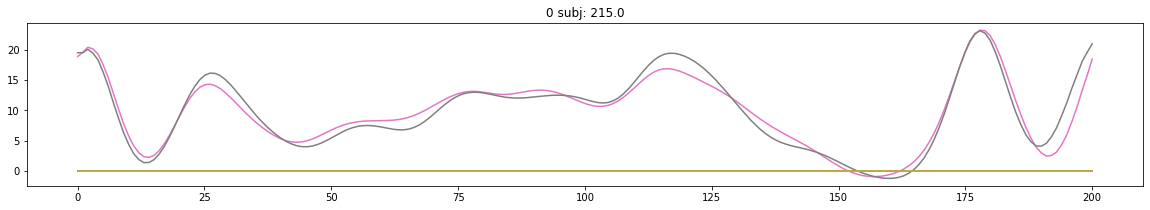

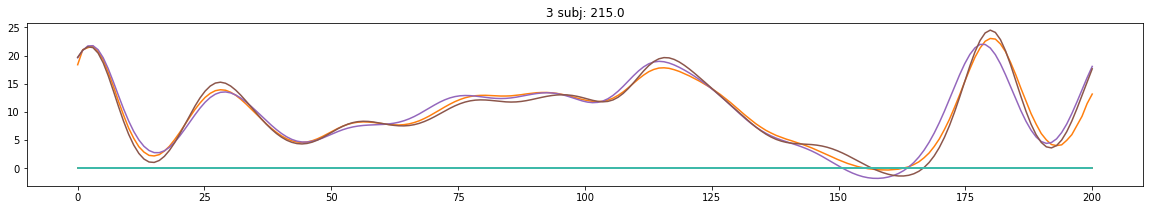

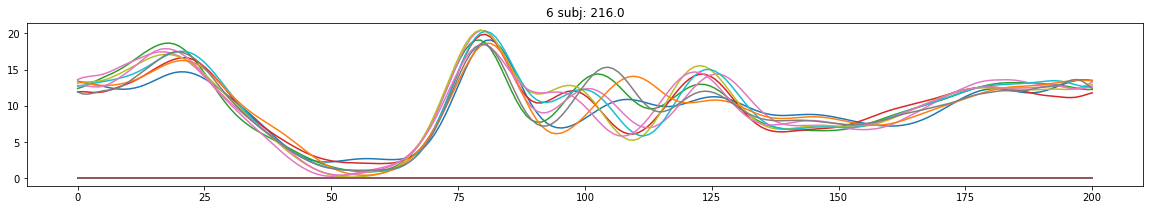

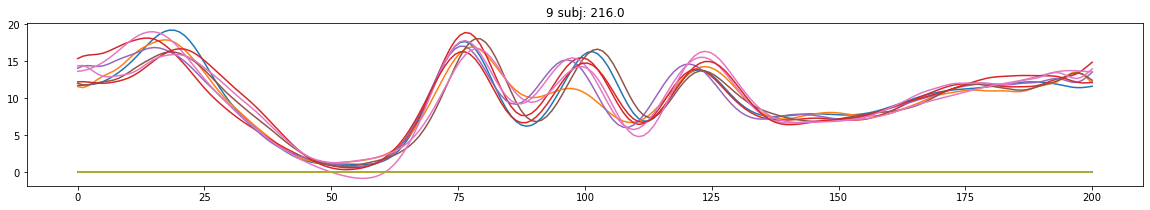

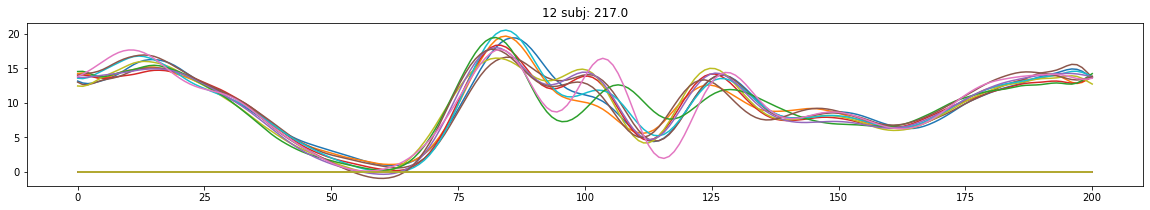

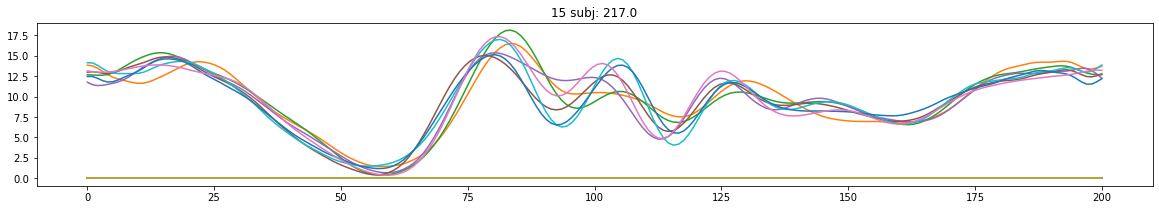

In [17]:
# Plot of cleaned data
for i in range(0,18): #(number_of_imputs):
# for i in range(number_of_imputs):

    for j in range(0,int(num_of_peaks[i])//2-1):#
        
        if training_label[i]==0:
#         if (j % 2) == 0:
            plt.rcParams["figure.figsize"] = (20,3)
#             plt.figure(3*i)
#             plt.title(str(i)+" subj: "+str(training_subject[i]))
#             plt.plot(np.linspace(0,resample_length,resample_length),training_data_cleaned[i,j,0:resample_length,0])
            
            plt.figure(3*i+1)
            plt.title(str(i)+" subj: "+str(training_subject[i]))
            plt.plot(np.linspace(0,resample_length,resample_length),training_data_cleaned[i,j,0:resample_length,1])
#             plt.figure(3*i+2)
#             plt.plot(np.linspace(0,resample_length,resample_length),training_data_cleaned[i,j,0:resample_length,2])


In [25]:
#Construct Training Input Array
#Only the valid data gets taken and assemled into one large array as the input for the model
#One input of the data contains one step and all axis as a flattened array

training_input_zeros=np.zeros((20000,3*resample_length))
training_input_label_zeros=np.zeros((20000))
                        
k=0
for i in range(number_of_imputs):
# for i in range(1):
    for j in range(int(num_of_peaks[i])//2-1):#
        
        if np.count_nonzero(training_data_cleaned[i,j,:,1])!=0:
#         nonzero_training_data_cleaned=training_data_cleaned[i,j,:,:]
        
            training_input_zeros[k,:200]=training_data_cleaned[i,j,:,0]
            training_input_zeros[k,200:400]=training_data_cleaned[i,j,:,1]
            training_input_zeros[k,400:600]=training_data_cleaned[i,j,:,2]
            training_input_label_zeros[k]=training_label[i]     
                                       
            k+=1   
            
training_input=np.zeros((k,3*resample_length))   
training_input_label=np.zeros((k))

training_input[:,:]=training_input_zeros[:k,:]
training_input_label[:]=training_input_label_zeros[:k]
print(len(training_input_label))
print(type(training_input))

44
<class 'numpy.ndarray'>


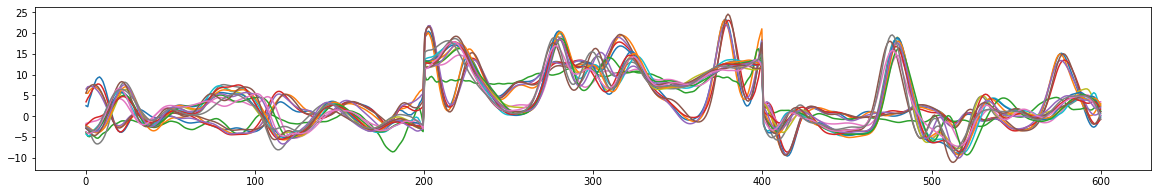

In [19]:
#Plot of the input for the network

plt.figure(1)
                 
# for i in range (training_input.shape[0]):
for i in range (0,18):
#     plt.title(str(i)+" subj: "+str(training_subject[i]))
    plt.plot(np.linspace(0,resample_length*3,resample_length*3),training_input[i,:])
#     plt.plot(np.linspace(0,100,100),training_input[i,:100])

In [43]:
# Finding Best Paramerers for Random Forest Classifier

## Data Preprocessing code ends here

In [51]:
print(tf.__version__)

2.6.1


In [44]:
# Number of trees in random forest
#n_estimators = 25,50,75,100,125,150,175,200,225,250,275,300
# Number of features to consider at every split
#max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
#max_depth = [2,5,7,10]
# Minimum number of samples required to split a node
#min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
#min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
#bootstrap = [True, False]

In [45]:
# from sklearn.model_selection import GridSearchCV
# # Create the parameter grid based on the results of random search 
# param_grid = {
#     'bootstrap': [True,False],
#     'max_depth': [2, 5, 7, 10],
#     'max_features': ['auto', 'sqrt'],
#     'min_samples_leaf': [2 ,3, 4, 5],
#     'min_samples_split': [2, 5],
#     'n_estimators': [50, 100, 200, 300]
# }
# # Create a based model
# rf = RandomForestClassifier()
# # Instantiate the grid search model
# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
#                           cv = 3, n_jobs = 4, verbose = 2)

In [46]:
# # Fit the grid search to the data
# grid_search.fit(training_input, training_input_label)
# grid_search.best_params_

In [47]:
from sklearn.model_selection import KFold

In [56]:
##### K-fold validation with a random forest classifier

#X = training_input ; y = training_input_label

#def K_fold(splits):
#    Total_accuracy=[]
#    Total_Precision=[]
#    Total_Recall=[]
#    Total_Fscore=[]
#    kf = KFold(n_splits=splits, random_state=None, shuffle=True)  # Declaring a class and its parameters. 
#    kf.get_n_splits(X)
#    print(kf)
#    for train_index, test_index in kf.split(X):
#        print("TRAIN:", train_index, "TEST:", test_index)
#        X_train, X_test = X[train_index], X[test_index]
#        y_train, y_test = y[train_index], y[test_index]

#        forest = RandomForestClassifier(n_estimators=100, criterion='gini',bootstrap=False, max_features='auto')
#        forest.fit(X_train[:], y_train)

#        y_pred = forest.predict(X_test[:])
#        print('Test Accuracy: %.3f' % accuracy_score(y_test, y_pred))
        confusion_matrix(y_test, y_pred,normalize='true')
        print(confusion_matrix(y_test, y_pred))
        #tp, fp, fn, tn = confusion_matrix(y_test, y_pred).ravel()
        #Accuracy of the model
        #accuracy = (tp+tn) / (tp+fp+fn+tn)
        #Misclassification_rate = (fp +fn) / (tp+fp+fn+tn)
        #precision=tp/(tp+fp)
        #recall=tp/(tp+fn)
        #F_Score=2*(precision*recall)/(precision+recall)
        #print(">Accuracy: " + str(round(accuracy,2)))
        #print(">Precision : " + str(precision))
        #print(">Recall : " + str(recall))
        #print(">F-Score : " + str(F_Score))
        #print(">Misclassification rate: " + str(round(Misclassification_rate,2)))
        
        #np.asarray(Total_accuracy.append(accuracy))
        #np.asarray(Total_Precision.append(precision))
        #np.asarray(Total_Recall.append(recall))
        #np.asarray(Total_Fscore.append(F_Score))
    #print(">>>Mean Testing Accuracy : " + str(round(np.mean(Total_accuracy),2)))
    #print(">>>Standard Deviation : " + str(round(np.std(Total_accuracy),2)))
    #print(">>>Mean Precision : " + str(round(np.mean(Total_Precision),2)))
    #print(">>>Mean Recall : " + str(round(np.mean(Total_Recall),2)))
    #print(">>>Mean F-Score : " + str(round(np.mean(Total_Fscore),2)))
    

    

In [57]:
kf = K_fold(2)    # Input No of Folds for Cross-Validation

KFold(n_splits=5, random_state=None, shuffle=True)
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 14 16 17 20 21 22 23 25 26 27 28 29
 31 32 33 36 37 38 39 40 41 42 43] TEST: [10 13 15 18 19 24 30 34 35]
Test Accuracy: 1.000
[[9]]
TRAIN: [ 0  1  2  3  4  5  6  7 10 11 12 13 14 15 16 18 19 20 21 23 24 25 28 29
 30 31 32 33 34 35 36 39 40 41 43] TEST: [ 8  9 17 22 26 27 37 38 42]
Test Accuracy: 1.000
[[8 0]
 [0 1]]
TRAIN: [ 1  2  3  4  6  8  9 10 11 13 14 15 16 17 18 19 20 22 23 24 25 26 27 28
 30 31 33 34 35 37 38 39 40 41 42] TEST: [ 0  5  7 12 21 29 32 36 43]
Test Accuracy: 1.000
[[8 0]
 [0 1]]
TRAIN: [ 0  1  2  3  5  7  8  9 10 11 12 13 15 17 18 19 21 22 24 25 26 27 29 30
 31 32 34 35 36 37 38 40 41 42 43] TEST: [ 4  6 14 16 20 23 28 33 39]
Test Accuracy: 1.000
[[9]]
TRAIN: [ 0  4  5  6  7  8  9 10 12 13 14 15 16 17 18 19 20 21 22 23 24 26 27 28
 29 30 32 33 34 35 36 37 38 39 42 43] TEST: [ 1  2  3 11 25 31 40 41]
Test Accuracy: 0.875
[[5 0 0]
 [1 0 0]
 [0 0 2]]


In [58]:
kf = KFold(n_splits=2, random_state=None, shuffle=True)  # Declaring a class and its parameters. 
kf.get_n_splits(training_input)
print(kf)
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    
    model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(600,)), 
    tf.keras.layers.Dense(1000, activation ='relu'),
    tf.keras.layers.Dense(500, activation ='relu'),
    tf.keras.layers.Dense(2, activation ='softmax')
    ])
    
    model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

        # train the neural network for 5 training epochs
    history=model.fit(X_train, y_train, epochs = 30);
    
    loss, accuracy = model.evaluate(X_test, y_test, verbose=2);

    print('Loss=', loss)
    print('accuracy=', accuracy)

KFold(n_splits=2, random_state=None, shuffle=True)
TRAIN: [ 1  2  3  5  6  7  8  9 11 12 19 20 21 23 27 28 30 32 33 37 39 42] TEST: [ 0  4 10 13 14 15 16 17 18 22 24 25 26 29 31 34 35 36 38 40 41 43]
Epoch 1/30


InvalidArgumentError:  Received a label value of 2 which is outside the valid range of [0, 2).  Label values: 0 0 0 0 0 0 0 0 2 0 0 0 1 0 0 0 0 0 0 0 0 0
	 [[node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits (defined at C:\Users\vibha\AppData\Local\Temp/ipykernel_23580/4256377310.py:22) ]] [Op:__inference_train_function_621]

Function call stack:
train_function


In [ ]:
t_d = np.zeros((800,60000,4))
print(t_d)